In [2]:
import tensorrt

In [3]:
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor
from qutip import Qobj, wigner

In [5]:
import tensorflow as tf

# Enable GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

tf.get_logger().setLevel('ERROR')

1 Physical GPUs, 1 Logical GPUs


In [6]:
# Utility functions
def get_vacuum_state_tf(dim):
    vacuum_state = qt.basis(dim, 0)
    return tf.convert_to_tensor(vacuum_state.full(), dtype=tf.complex64)

def tf_annihilation(dim):
    diag_vals = tf.math.sqrt(tf.cast(tf.range(1, dim), dtype=tf.float32))
    diag_vals = tf.cast(diag_vals, dtype=tf.complex64)
    return tf.linalg.diag(diag_vals, k=1)

def tf_number(dim):
    diag_vals = tf.range(0.0, dim, dtype=tf.float32)
    diag_vals = tf.cast(diag_vals, dtype=tf.complex64)
    return tf.linalg.diag(diag_vals)

def tf_displacement_operator(dim, alpha):
    alpha = tf.cast(alpha, dtype=tf.complex64)
    a = tf_annihilation(dim)
    term1 = alpha * tf.linalg.adjoint(a)
    term2 = tf.math.conj(alpha) * a
    D = tf.linalg.expm(term1 - term2)
    return D

def tf_displacement_encoding(dim, alpha_vec):
    alpha_vec = tf.cast(alpha_vec, dtype=tf.complex64)
    num = tf.shape(alpha_vec)[0]
    a = tf_annihilation(dim)
    term1 = tf.linalg.adjoint(a)
    term2 = a
    term1_batch = tf.tile(tf.expand_dims(term1, 0), [num, 1, 1])
    term2_batch = tf.tile(tf.expand_dims(term2, 0), [num, 1, 1])
    alpha_vec = tf.reshape(alpha_vec, [-1, 1, 1])
    D = tf.linalg.expm(alpha_vec * term1_batch - tf.math.conj(alpha_vec) * term2_batch)
    return D

def tf_rotation_operator(dim, theta):
    theta = tf.cast(theta, dtype=tf.complex64)
    n = tf_number(dim)
    R = tf.linalg.expm(-1j * theta * n)
    return R

def tf_squeezing_operator(dim, r):
    r = tf.cast(r, dtype=tf.complex64)
    a = tf_annihilation(dim)
    term1 = r * tf.linalg.adjoint(a) * a
    term2 = tf.math.conj(r) * a * tf.linalg.adjoint(a)
    S = tf.linalg.expm(0.5 * (term1 - term2))
    return S

def tf_kerr_operator(dim, kappa):
    kappa = tf.cast(kappa, dtype=tf.complex64)
    n = tf_number(dim)
    K = tf.linalg.expm(1j * kappa * n * n)
    return K

In [7]:
# TensorFlow Custom Layer for Quantum Encoding
class QuantumEncodingLayer(tf.keras.layers.Layer):
    def __init__(self, dim, vacuum_state, **kwargs):
        super(QuantumEncodingLayer, self).__init__(**kwargs)
        self.dim = dim
        self.vacuum_state = vacuum_state

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        batch_vacuum_state = tf.tile(tf.expand_dims(self.vacuum_state, axis=0), [batch_size, 1, 1])
        batch_displacement_operators = tf_displacement_encoding(self.dim, inputs)
        displaced_states = tf.einsum('bij,bjk->bik', batch_displacement_operators, batch_vacuum_state)
        return displaced_states

In [8]:
# TensorFlow Custom Layer for Quantum Transformations
class QuantumLayer(tf.keras.layers.Layer):
    def __init__(self, dim, **kwargs):
        super(QuantumLayer, self).__init__(**kwargs)
        self.dim = dim
        self.final_state = None

    def build(self, input_shape):
        initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed = 42)
        self.theta_1 = self.add_weight("theta_1", shape=[1,], initializer=initializer, trainable=True)
        self.theta_2 = self.add_weight("theta_2", shape=[1,], initializer=initializer, trainable=True)
        self.r = self.add_weight("r", shape=[1,], initializer=initializer, trainable=True)
        self.b = self.add_weight("b", shape=[1,], initializer=initializer, trainable=True)
        self.kappa = self.add_weight("kappa", shape=[1,], initializer=initializer, trainable=True)

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]

        # Compute operator tensors dynamically based on the current trainable variables
        D_tensor = tf.expand_dims(tf_displacement_operator(self.dim, self.b), 0)
        R_tensor_1 = tf.expand_dims(tf_rotation_operator(self.dim, self.theta_1), 0)
        S_tensor = tf.expand_dims(tf_squeezing_operator(self.dim, self.r), 0)
        R_tensor_2 = tf.expand_dims(tf_rotation_operator(self.dim, self.theta_2), 0)
        K_tensor = tf.expand_dims(tf_kerr_operator(self.dim, self.kappa), 0)

        # Tile the operator tensors for batch processing
        D_tensor = tf.tile(D_tensor, [batch_size, 1, 1])
        R_tensor_1 = tf.tile(R_tensor_1, [batch_size, 1, 1])
        S_tensor = tf.tile(S_tensor, [batch_size, 1, 1])
        R_tensor_2 = tf.tile(R_tensor_2, [batch_size, 1, 1])
        K_tensor = tf.tile(K_tensor, [batch_size, 1, 1])

        transformed_state = tf.einsum('bij,bjk->bik', R_tensor_1, inputs)
        transformed_state = tf.einsum('bij,bjk->bik', S_tensor, transformed_state)
        transformed_state = tf.einsum('bij,bjk->bik', R_tensor_2, transformed_state)
        transformed_state = tf.einsum('bij,bjk->bik', D_tensor, transformed_state)
        
        activated_state = tf.einsum('bij,bjk->bik', K_tensor, transformed_state)
        self.final_state = activated_state
        return activated_state

In [9]:
# TensorFlow Custom Layer for Quantum Decoding
class QuantumDecodingLayer(tf.keras.layers.Layer):
    def __init__(self, dim, **kwargs):
        super(QuantumDecodingLayer, self).__init__(**kwargs)
        self.dim = dim
        self.x_operator = self.build_x_operator()

    def build_x_operator(self):
        a = tf_annihilation(self.dim)
        x_operator = (a + tf.linalg.adjoint(a)) / 2.0
        x_operator = tf.expand_dims(x_operator, axis=0)  # Add batch dimension
        return x_operator

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        batch_x_operator = tf.tile(self.x_operator, [batch_size, 1, 1])

        # Step 1: Compute \hat{O} | \psi \rangle for each state in the batch
        operator_applied_state = tf.einsum('bij,bjk->bik', batch_x_operator, inputs)

        # Take the complex conjugate of each state and adjust dimensions
        conj_inputs = tf.math.conj(inputs)  # Shape: (batch_size, dim, 1)
        conj_inputs_adj = tf.transpose(conj_inputs, perm=[0, 2, 1])  # Shape: (batch_size, 1, dim)

        # Compute the expectation value (inner product) for each state in the batch
        x_expectation = tf.einsum('bij,bjk->bi', conj_inputs_adj, operator_applied_state) 
        x_expectation = tf.squeeze(x_expectation, axis=-1)

        return tf.cast(x_expectation, dtype=tf.float32)

In [10]:
class WignerNegativityCallback(tf.keras.callbacks.Callback):
    def __init__(self, model, last_layer_index, dim, xvec, dx, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.model = model
        self.last_layer_index = last_layer_index
        self.dim = dim
        self.xvec = xvec
        self.dx = dx
        self.wigner_negativities = []

    def compute_negativity(self, state_ket_array):
        state_ket_reshaped = state_ket_array.squeeze()
        state_ket = Qobj(state_ket_reshaped).unit()  # Convert to Qobj
        wigner_func = wigner(state_ket, self.xvec, self.xvec)
        da = self.dx * self.dx
        return np.log(np.sum(np.abs(wigner_func)*da))

    def on_epoch_end(self, epoch, logs=None):
        quantum_output = tf.keras.Model(inputs=self.model.input, 
                                            outputs=self.model.layers[self.last_layer_index].output)
        
        # Predict to get the quantum states
        quantum_states = quantum_output.predict(self.xvec, verbose = 0)

        # Prepare the states for parallel processing
        state_kets_arrays = [quantum_states[i, :, 0] for i in range(quantum_states.shape[0])]

        # Use ThreadPoolExecutor to parallelize the computation
        with ThreadPoolExecutor() as executor:
            negativities = list(executor.map(self.compute_negativity, state_kets_arrays))

        # Average negativity over the batch
        avg_negativity = np.mean(negativities)
        self.wigner_negativities.append(avg_negativity)

    def get_wigner_negativities(self):
        return self.wigner_negativities

In [11]:
def plot_results(models, histories, quantumness, configs, cutoff, x_data, y_data, y_data_noisy):
    # Figure 1: 6 Fit Plots
    fig1, axes1 = plt.subplots(2, 3, figsize=(15, 10))
    axes1 = axes1.flatten()
    for i, model in enumerate(models):
        y_pred = model.predict(x_data, verbose=0)
        axes1[i].scatter(x_data, y_data_noisy, s=5, label='Noisy Data')
        axes1[i].plot(x_data, y_pred, label='Fitted Curve', color='r')
        axes1[i].plot(x_data, y_data, label='True Curve', color='g')
        axes1[i].legend()
        axes1[i].set_title(f'Model {i+1}')
        
    plt.tight_layout()

    # Figure 2: Loss History Plots
    fig2, axes2 = plt.subplots(1, 2, figsize=(15, 5))
    # Loss for varying cutoff dimension
    for i in range(len(cutoff)):
        axes2[0].plot(histories[i].history['loss'], label=f'Cutoff: {cutoff[i]}')
    axes2[0].set_title('Loss for Varying Cutoff Dimension')
    axes2[0].set_xlabel('Epoch')
    axes2[0].set_ylabel('MSE Loss')
    axes2[0].legend()

    # Loss for varying number of layers
    for i in range(len(configs)):
        axes2[1].plot(histories[i + len(cutoff)].history['loss'], label=f'Layers: {configs[i][0]}')
    axes2[1].set_title('Loss for Varying Number of Layers')
    axes2[1].set_xlabel('Epoch')
    axes2[1].set_ylabel('MSE Loss')
    axes2[1].legend()

    plt.tight_layout()

    # Figure 3: Loss and Validation Loss for Each Model
    fig3, axes3 = plt.subplots(2, 3, figsize=(15, 10))
    axes3 = axes3.flatten()
    for i in range(len(models)):
        axes3[i].plot(histories[i].history['loss'], label='Training Loss')
        axes3[i].plot(histories[i].history['val_loss'], label='Validation Loss')
        axes3[i].set_title(f'Model {i+1} Loss vs Epochs')
        axes3[i].set_xlabel('Epoch')
        axes3[i].set_ylabel('MSE Loss')
        axes3[i].legend()
        
    plt.tight_layout()

    # Figure 4: Quantumness Plot for Each Model
    fig4, ax = plt.subplots(figsize=(10, 6))
    for i, quants in enumerate(quantumness):
        ax.plot(quants, label=f'Model {i+1} Quantumness')

    ax.set_title('Quantumness vs Epochs for All Models')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Average Wigner Negativity')
    ax.legend()
    
    plt.tight_layout()

    # Save and show all figures
    fig1.savefig('fits.png', facecolor='white')
    fig2.savefig('mses.png', facecolor='white')
    fig3.savefig('mse_with_val.png', facecolor='white')
    fig4.savefig('quantumness.png', facecolor='white')
    plt.show()

In [12]:
# Function for training models with different configurations
def train_models(x_data, y_data_noisy, cutoff_dim = [10], configs = [(6, 50)]):
    trained_models = []
    histories = []
    quantumness = []
    
    if len(cutoff_dim) == 1:
        for num_layers, epochs in configs:
            # Create a new model for each configuration
            vacuum_state = get_vacuum_state_tf(cutoff_dim[0])
            model = tf.keras.Sequential([QuantumEncodingLayer(dim=cutoff_dim[0], vacuum_state=vacuum_state, name='QuantumEncoding')])
            for i in range(num_layers):
                model.add(QuantumLayer(dim=cutoff_dim[0], name=f'QuantumLayer_{i+1}'))
            model.add(QuantumDecodingLayer(dim=cutoff_dim[0], name='QuantumDecoding'))
    
            # Compile and train the model
            model.compile(optimizer='adam', loss='mse')
            print(f'Training model with {num_layers} layers for {epochs} epochs...')
            wigner_callback = WignerNegativityCallback(model, -2, dim=cutoff_dim[0], xvec=x_data, dx = x_data[0]-x_data[1])
            history = model.fit(x_data, y_data_noisy, validation_split=0.30, epochs=epochs, verbose=0, callbacks=wigner_callback)
            print('Training Complete.')
            
            # Store the trained model and its history
            histories.append(history)
            trained_models.append(model)
            quantumness.append(wigner_callback.get_wigner_negativities())
    else:
        for cutoff in cutoff_dim:
            # Create a new model for each configuration
            num_layers, epochs = configs[0]
            vacuum_state = get_vacuum_state_tf(cutoff)
            model = tf.keras.Sequential([QuantumEncodingLayer(dim=cutoff, vacuum_state=vacuum_state, name='QuantumEncoding')])
            for i in range(num_layers):
                model.add(QuantumLayer(dim=cutoff, name=f'QuantumLayer_{i+1}'))
            model.add(QuantumDecodingLayer(dim=cutoff, name='QuantumDecoding'))
    
            # Compile and train the model
            model.compile(optimizer='adam', loss='mse')
            print(f'Training model with {num_layers} layers of {cutoff} dimensions...')
            wigner_callback = WignerNegativityCallback(model, -2, dim=cutoff, xvec=x_data, dx = x_data[0]-x_data[1])
            history = model.fit(x_data, y_data_noisy, validation_split=0.30, epochs=epochs, verbose=0, callbacks=wigner_callback)
            print('Training Complete.')
    
            # Store the trained model and its history
            histories.append(history)
            trained_models.append(model)
            quantumness.append(wigner_callback.get_wigner_negativities())

    return trained_models, histories, quantumness

Training model with 2 layers for 50 epochs...


2023-11-18 16:46:21.306147: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x8bc19e0
2023-11-18 16:46:21.446779: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f2bb801ec20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-18 16:46:21.446840: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1050, Compute Capability 6.1
2023-11-18 16:46:21.522242: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-18 16:46:21.650372: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8906
2023-11-18 16:46:22.326786: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Training Complete.
Training model with 4 layers for 50 epochs...
Training Complete.
Training model with 6 layers for 50 epochs...
Training Complete.
Training model with 6 layers of 5 dimensions...
Training Complete.
Training model with 6 layers of 10 dimensions...
Training Complete.
Training model with 6 layers of 15 dimensions...
Training Complete.


/home/songofphysics/miniconda3/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/songofphysics/miniconda3/lib/python3.11/site-packages/matplotlib/collections.py:194: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/home/songofphysics/miniconda3/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


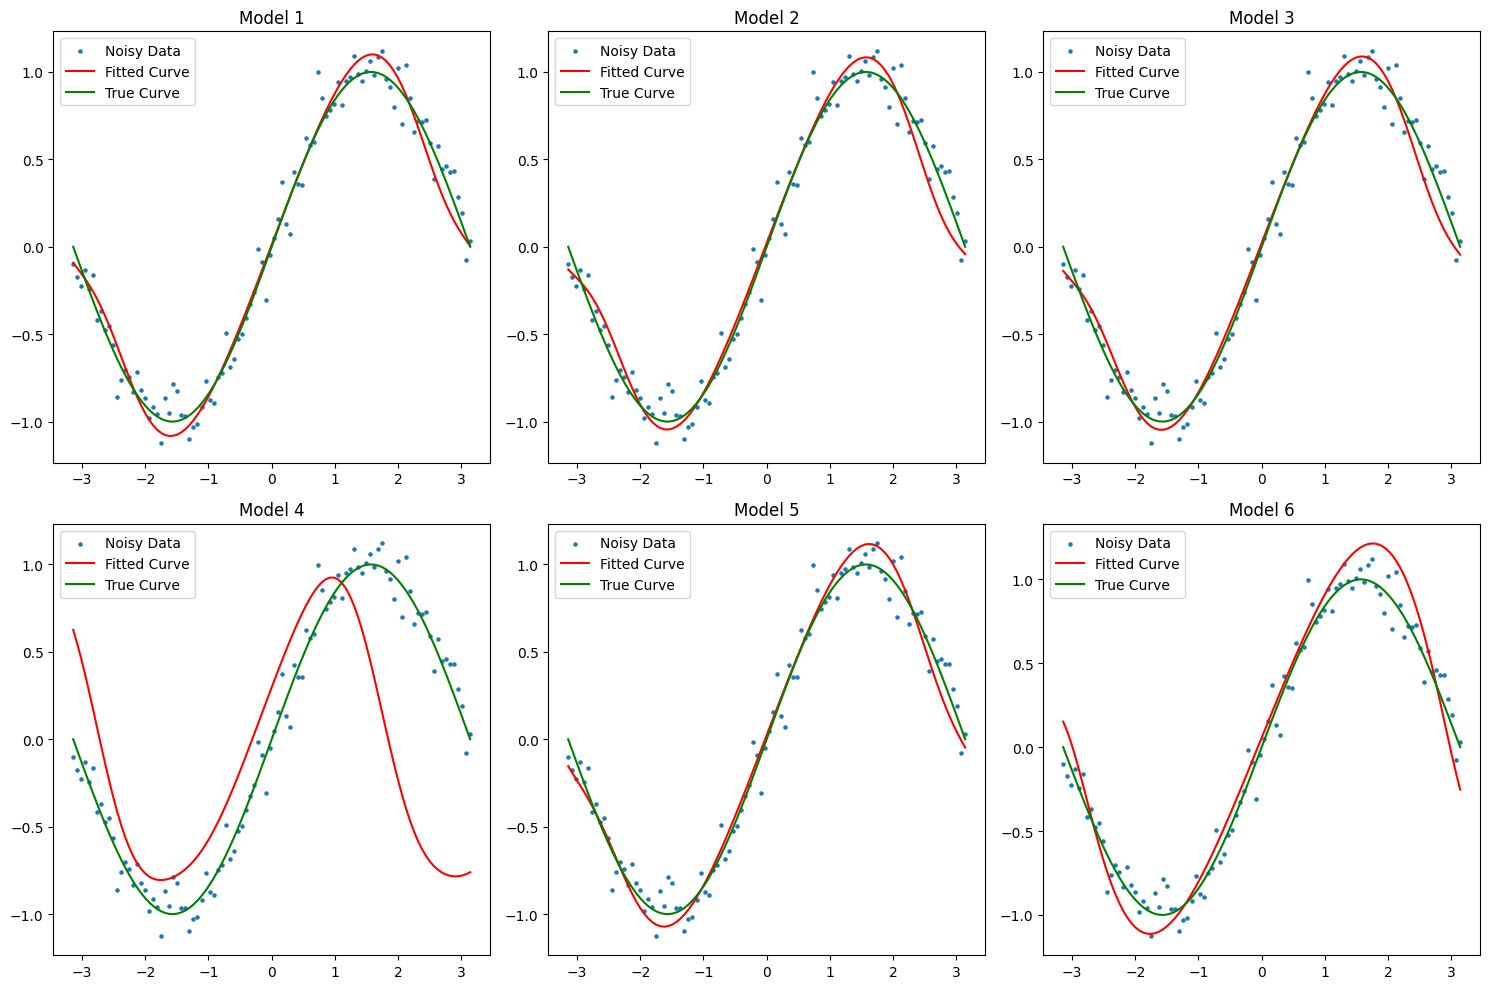

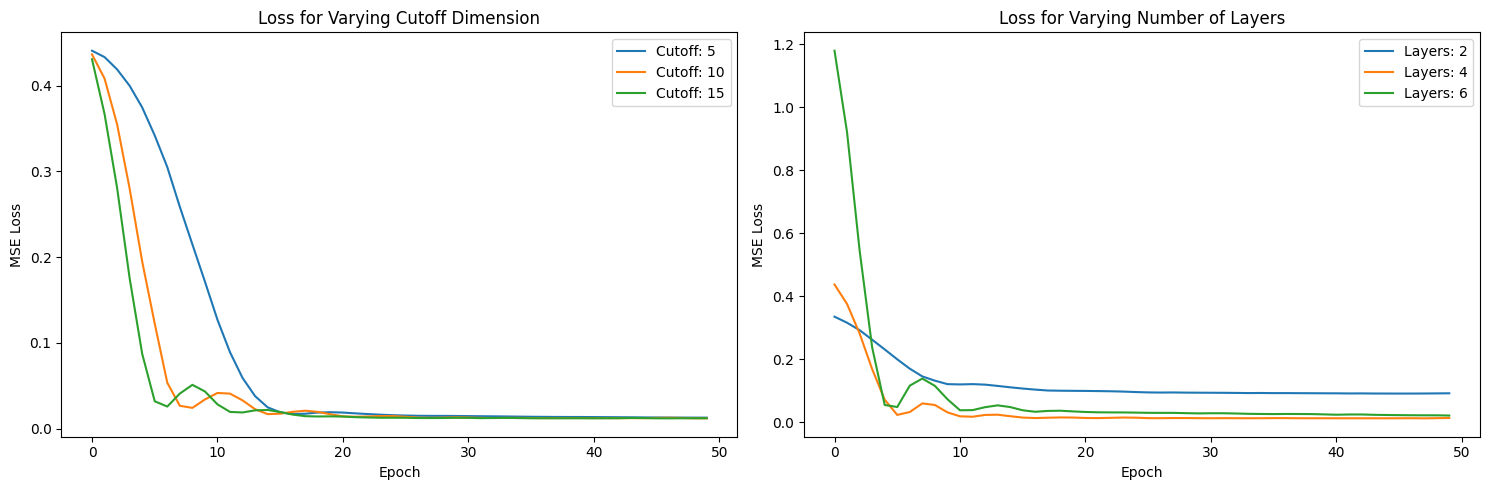

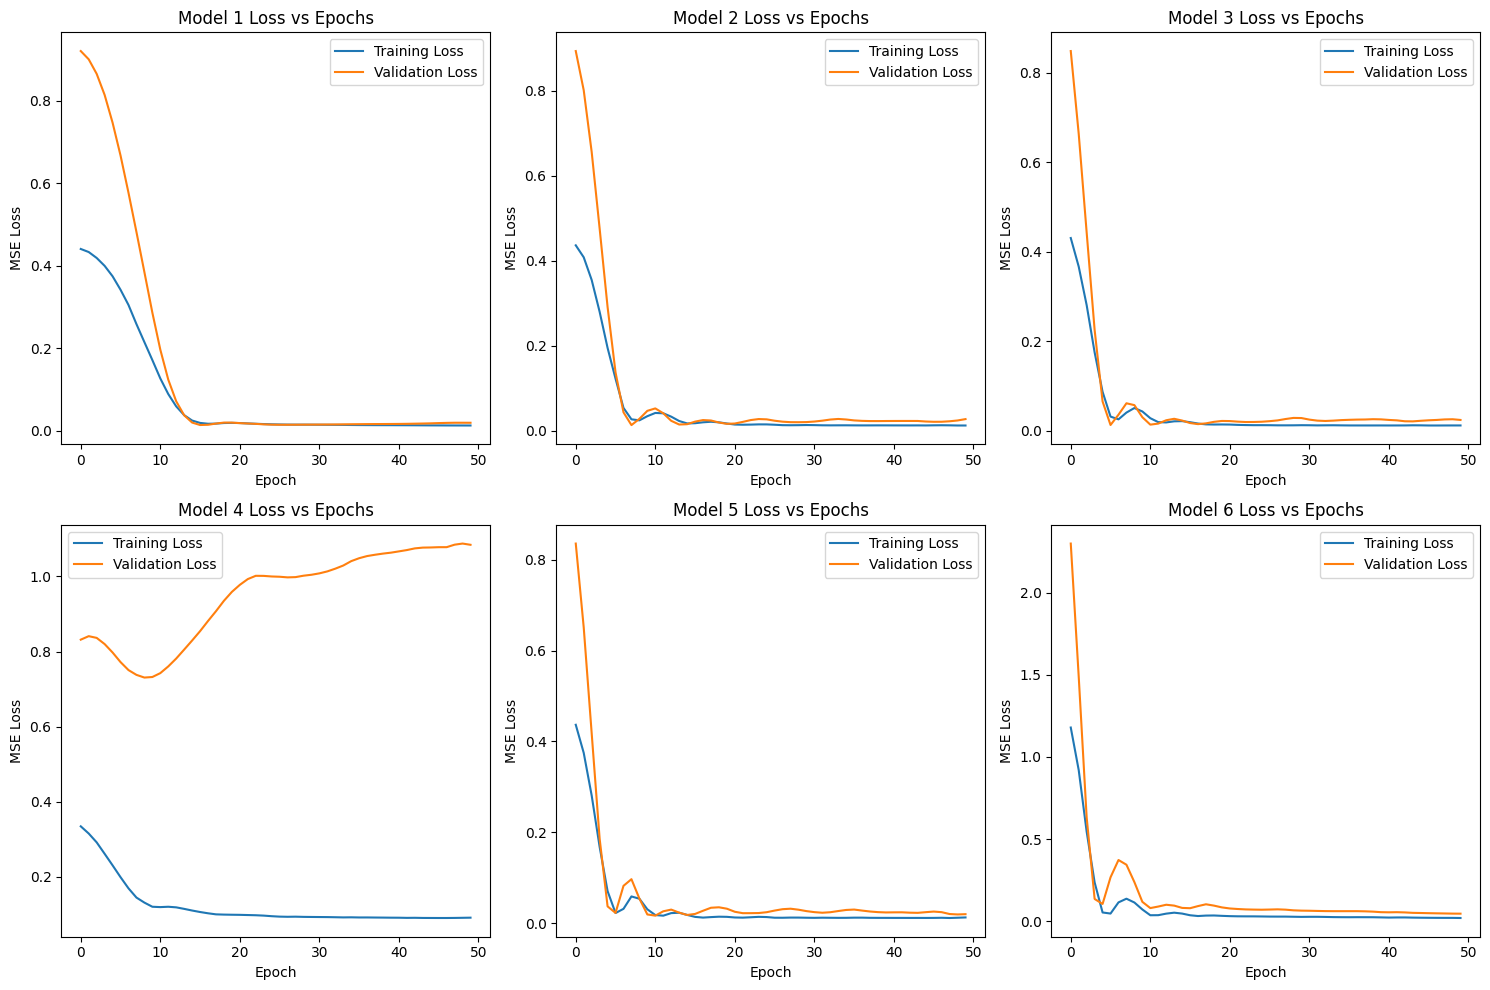

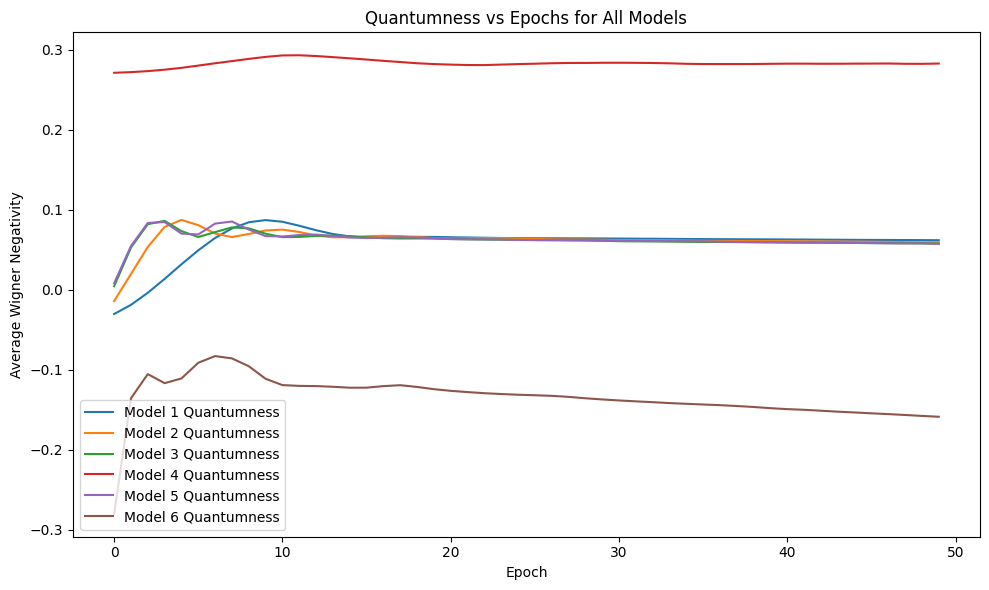

In [13]:
num_layers = 6
cutoff_dim = [5, 10, 15] 

# Generate sine wave data
num_points = 100
x_data = np.linspace(-np.pi, np.pi, num_points)
y_data = np.sin(x_data)

# Add noise
noise_level = 0.1
y_data_noisy = y_data + noise_level * np.random.randn(num_points)

# Reshape for the model
x_data = x_data.astype(np.complex64).reshape(-1, 1)
y_data_noisy = y_data_noisy.astype(np.float32).reshape(-1, 1)

configs = [
    (2, 50),
    (4, 50),
    (6, 50)
]

trained_models, histories, quantumness = train_models(x_data, y_data_noisy, configs = configs)
trained_models2, histories2, quantumness2 = train_models(x_data, y_data_noisy, cutoff_dim = cutoff_dim)

trained_models += trained_models2
histories += histories2
quantumness += quantumness2

plot_results(trained_models, histories, quantumness, configs, cutoff_dim, x_data, y_data, y_data_noisy)